In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.stats import skew
from sklearn import preprocessing
from scipy.stats import mode
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

In [42]:
train = pd.read_csv(r"C:\Users\PRADYUM\Desktop\Task 3\carInsurance_train.csv")
test = pd.read_csv(r"C:\Users\PRADYUM\Desktop\Task 3\carInsurance_test.csv")

In [43]:
train.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


In [44]:
train.shape

(4000, 19)

In [45]:
train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


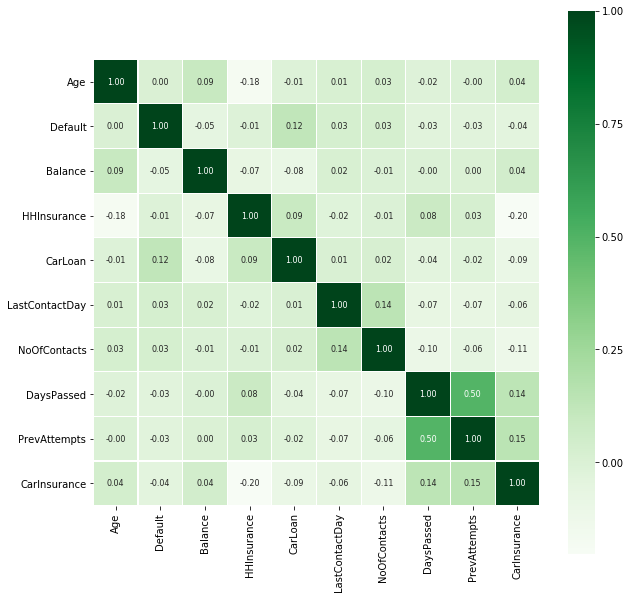

In [46]:
cor=train.corr()
cor = cor.drop(['Id'],axis=1).drop(['Id'],axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(cor,cmap=plt.cm.Greens,annot=True,fmt='.2f',square=True,annot_kws={'size':8},linewidths=0.1)

In [47]:
train.dtypes

Id                   int64
Age                  int64
Job                 object
Marital             object
Education           object
Default              int64
Balance              int64
HHInsurance          int64
CarLoan              int64
Communication       object
LastContactDay       int64
LastContactMonth    object
NoOfContacts         int64
DaysPassed           int64
PrevAttempts         int64
Outcome             object
CallStart           object
CallEnd             object
CarInsurance         int64
dtype: object

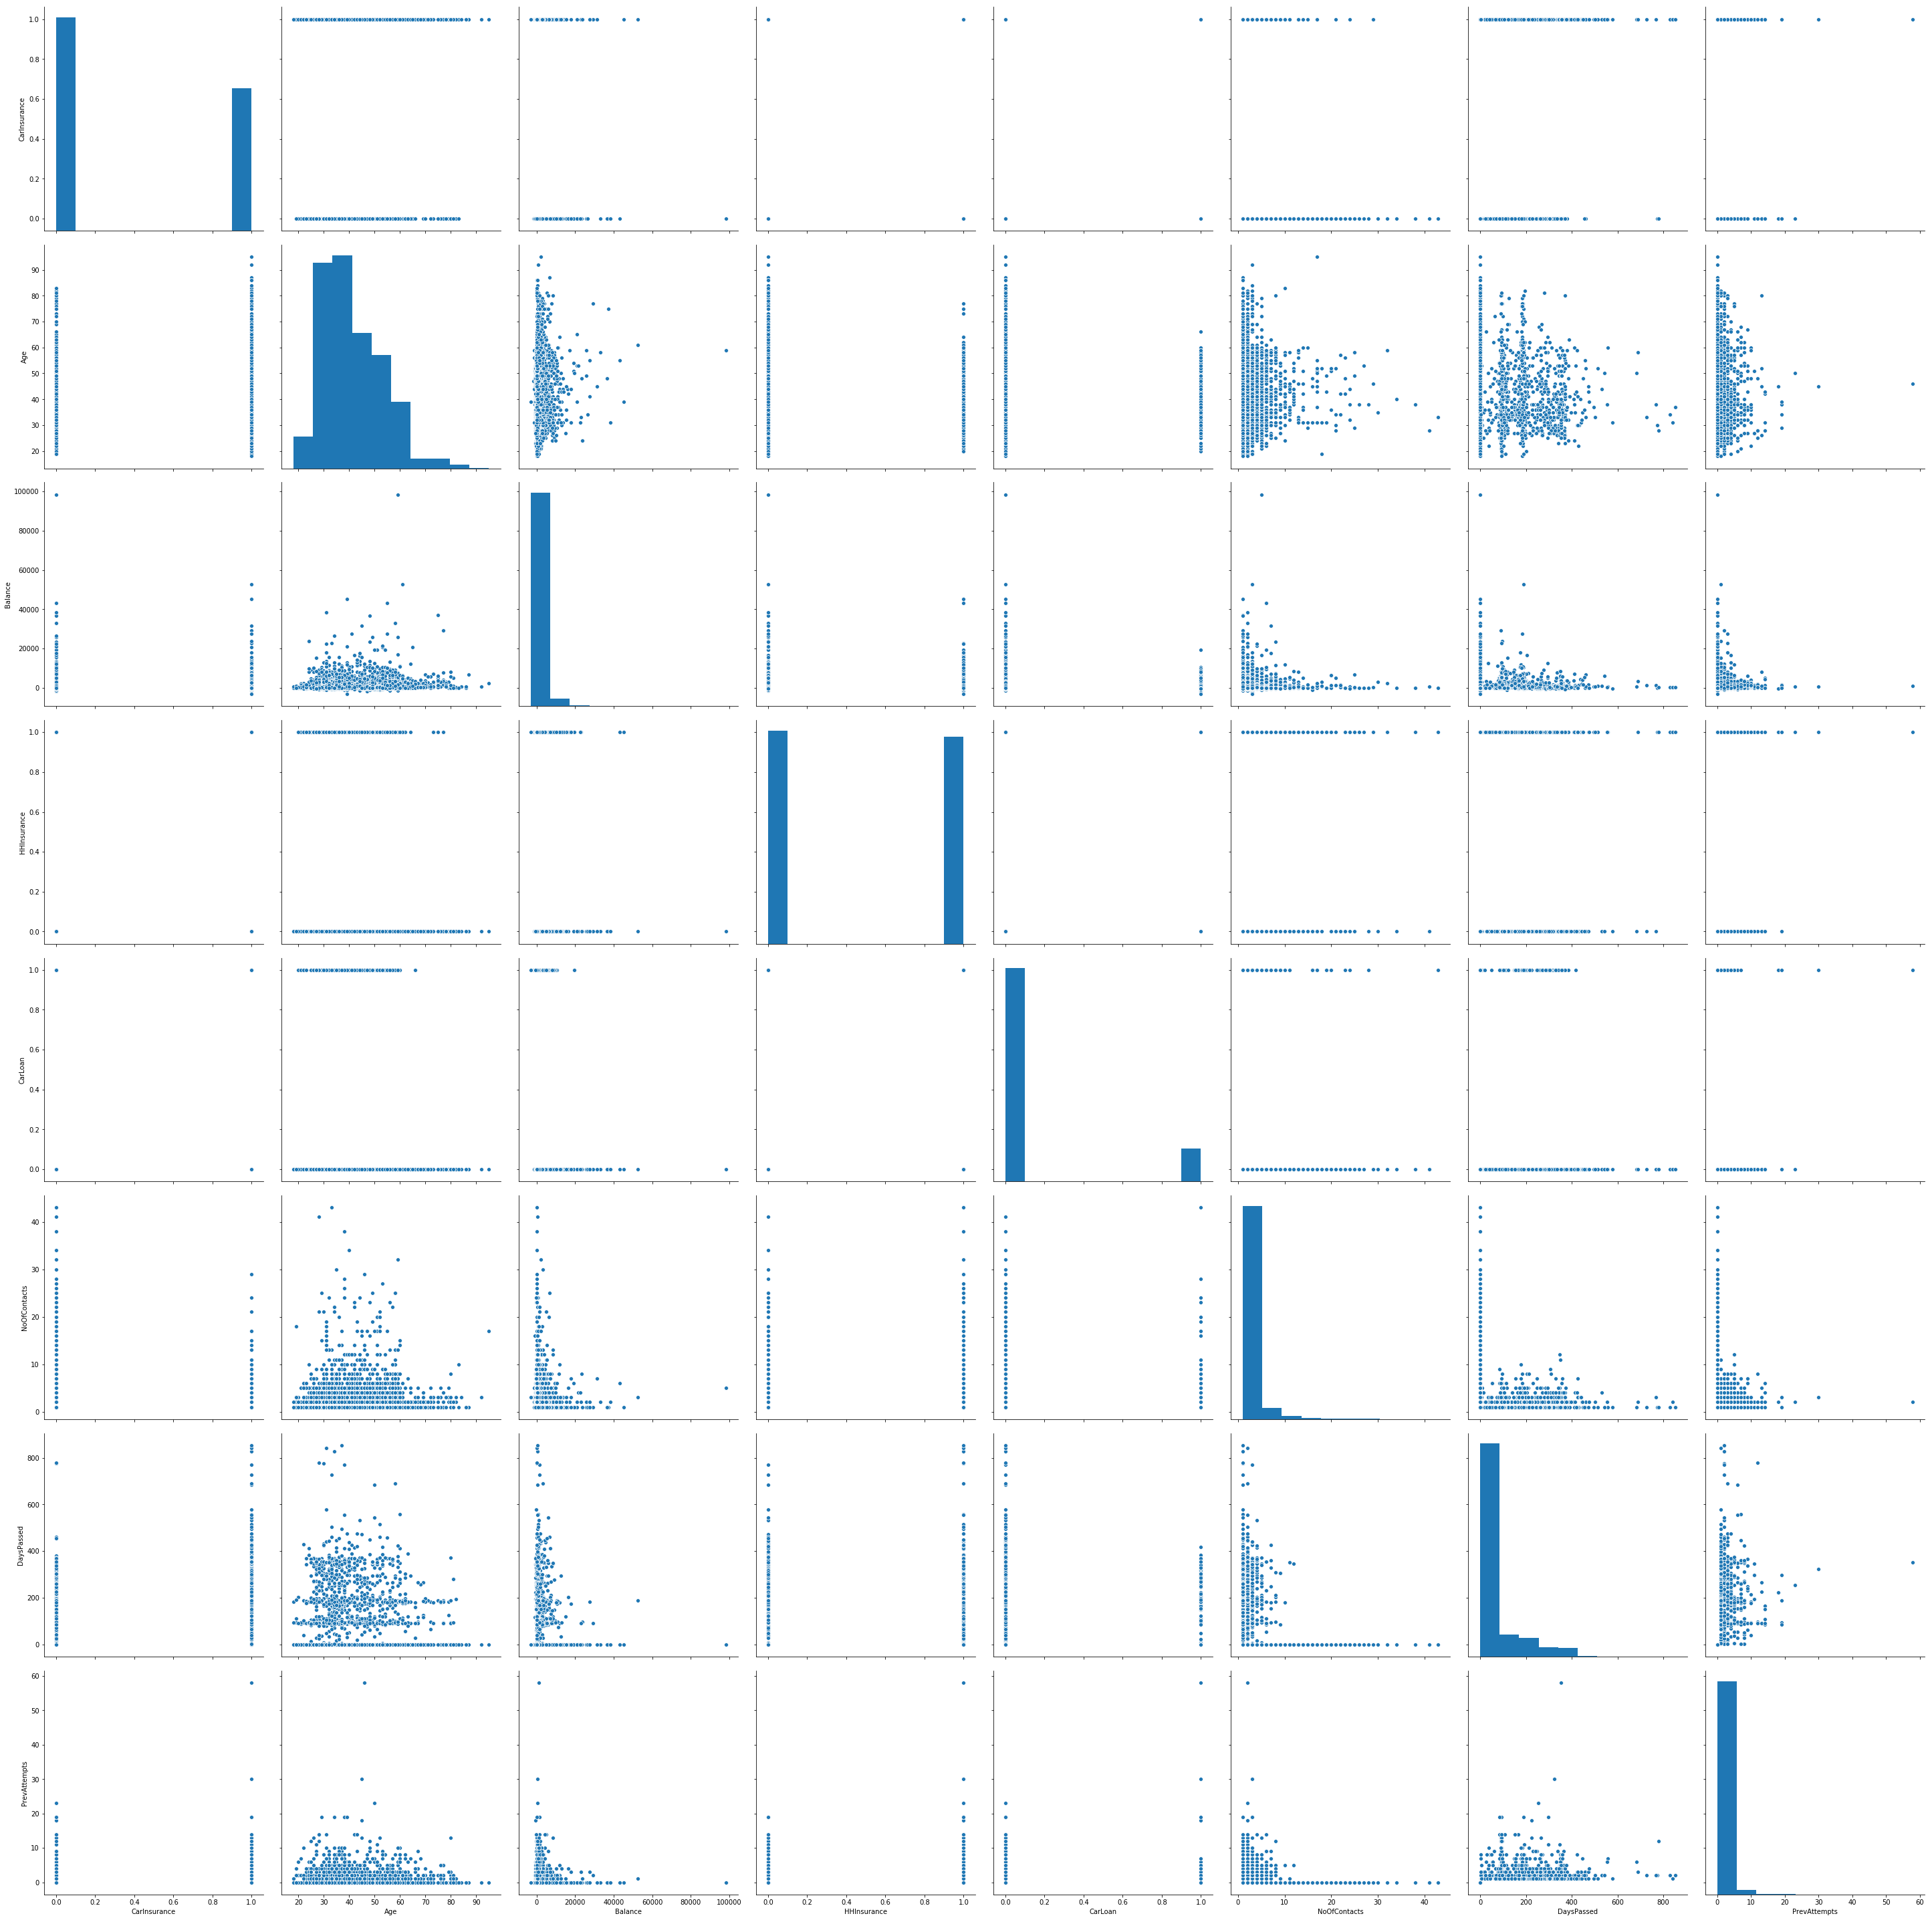

In [48]:
imp_feats = ['CarInsurance','Age','Balance','HHInsurance', 'CarLoan','NoOfContacts','DaysPassed','PrevAttempts']
sns.pairplot(train[imp_feats], palette = "viridis", height=5)
plt.show()

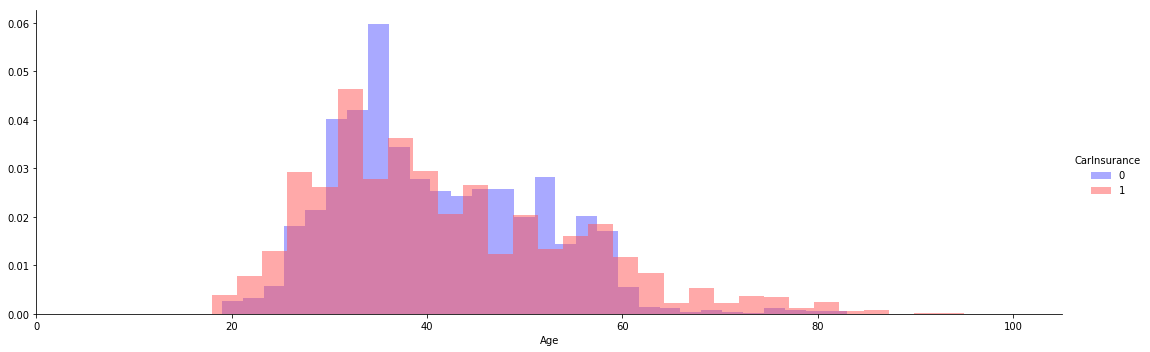

In [49]:
facet = sns.FacetGrid(train, hue='CarInsurance',height=5,aspect=3,palette='seismic')
facet.map(plt.hist,'Age',bins=30,alpha=0.5,density=True)
facet.set(xlim=(0,train.Age.max()+10))
facet.add_legend()

#### People with age less than 30 are more likely

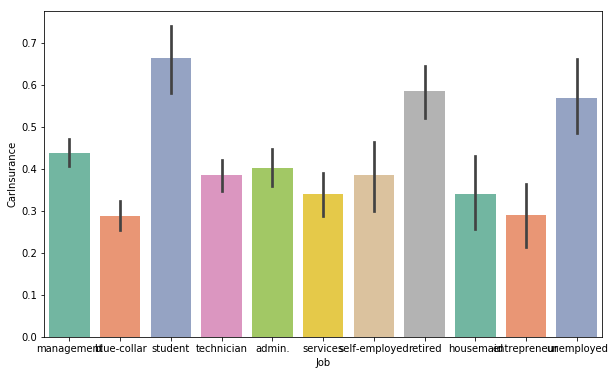

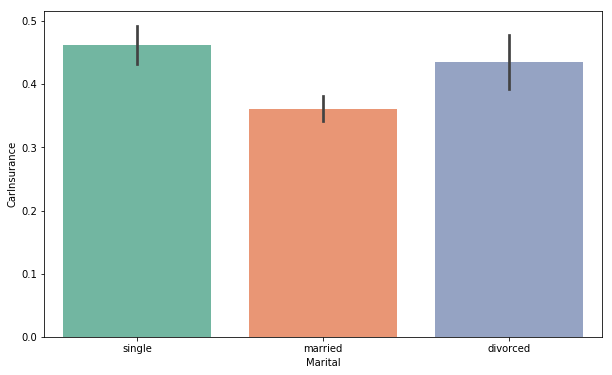

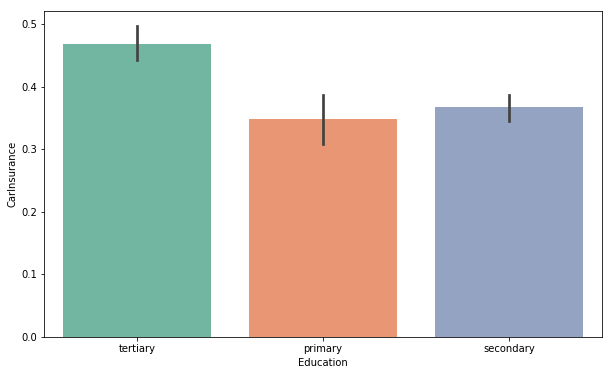

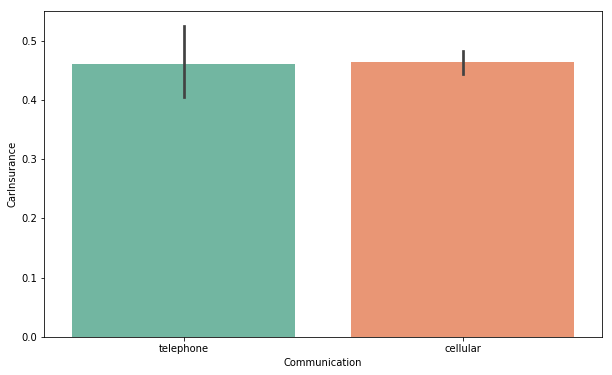

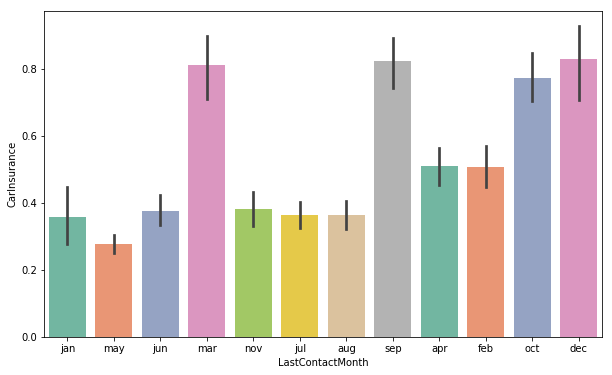

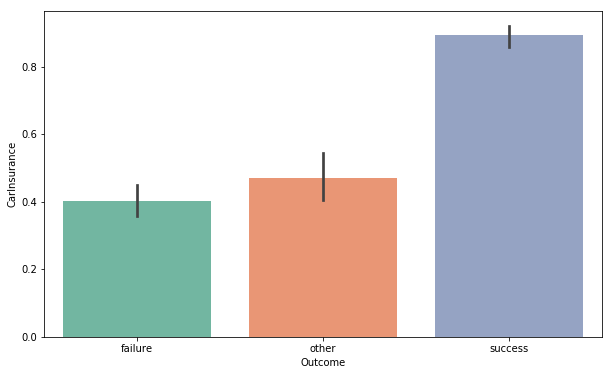

In [50]:
cat_feats = train.select_dtypes(include=['object']).columns
plt_feats = cat_feats[(cat_feats!= 'CallStart') & (cat_feats!='CallEnd')]

for feature in plt_feats:
    plt.figure(figsize=(10,6))
    sns.barplot(feature,'CarInsurance', data=train,palette='Set2')

In [51]:
train[train['Balance']>80000]
train = train.drop(train[train.index==1742].index)

### DEALING WITH MISSING VALUES

In [52]:
# merge train and test data here in order to impute missing values all at once
all=pd.concat([train,test],keys=('train','test'),sort=True)
all.drop(['CarInsurance','Id'],axis=1,inplace=True)
print(all.shape)

(4999, 17)


In [53]:
total = all.isnull().sum()
pct = total/all.isnull().count()
NAs = pd.concat([total,pct],axis=1,keys=('Total','Pct'))
NAs[NAs.Total>0].sort_values(by='Total',ascending=False)

,Total,Pct
Outcome,3798,0.759752
Communication,1123,0.224645
Education,216,0.043209
Job,24,0.004801


In [54]:
all_df = all.copy()

# Fill missing outcome as not in previous campaign
all_df[all_df['DaysPassed']==-1].count()
all_df.loc[all_df['DaysPassed']==-1,'Outcome']='NoPrev'

# Fill missing communication with none 
all_df['Communication'].value_counts()
all_df['Communication'].fillna('None',inplace=True)

# Fill missing education with the most common education level by job type
all_df['Education'].value_counts()

# Create job-education level mode mapping
edu_mode=[]
job_types = all_df.Job.value_counts().index
for job in job_types:
    mode = all_df[all_df.Job==job]['Education'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=all_df.Job.value_counts().index)

# Apply the mapping to missing eductaion obs
for j in job_types:
    all_df.loc[(all_df['Education'].isnull()) & (all_df['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]
all_df['Education'].fillna('None',inplace=True)

# Fill missing job with none
all_df['Job'].fillna('None',inplace=True)

# Double check if there is still any missing value
all_df.isnull().sum().sum()

0

### Features

In [55]:
# First simplify some client features

# Create age group based on age bands
all_df['AgeBand']=pd.cut(all_df['Age'],5)
print(all_df['AgeBand'].value_counts())

all_df.loc[(all_df['Age']>=17) & (all_df['Age']<34),'AgeBin'] = 1
all_df.loc[(all_df['Age']>=34) & (all_df['Age']<49),'AgeBin'] = 2
all_df.loc[(all_df['Age']>=49) & (all_df['Age']<65),'AgeBin'] = 3
all_df.loc[(all_df['Age']>=65) & (all_df['Age']<80),'AgeBin'] = 4
all_df.loc[(all_df['Age']>=80) & (all_df['Age']<96),'AgeBin'] = 5
all_df['AgeBin'] = all_df['AgeBin'].astype(int)

# Create balance groups
all_df['BalanceBand']=pd.cut(all_df['Balance'],5)
print(all_df['BalanceBand'].value_counts())
all_df.loc[(all_df['Balance']>=-3200) & (all_df['Balance']<17237),'BalanceBin'] = 1
all_df.loc[(all_df['Balance']>=17237) & (all_df['Balance']<37532),'BalanceBin'] = 2
all_df.loc[(all_df['Balance']>=37532) & (all_df['Balance']<57827),'BalanceBin'] = 3
all_df.loc[(all_df['Balance']>=57827) & (all_df['Balance']<78122),'BalanceBin'] = 4
all_df.loc[(all_df['Balance']>=78122) & (all_df['Balance']<98418),'BalanceBin'] = 5
all_df['BalanceBin'] = all_df['BalanceBin'].astype(int)

all_df = all_df.drop(['AgeBand','BalanceBand','Age','Balance'],axis=1)

# Convert education level to numeric 
all_df['Education'] = all_df['Education'].replace({'None':0,'primary':1,'secondary':2,'tertiary':3})

(33.4, 48.8]      2184
(17.923, 33.4]    1508
(48.8, 64.2]      1147
(64.2, 79.6]       133
(79.6, 95.0]        27
Name: AgeBand, dtype: int64
(-3113.645, 8071.0]    4847
(8071.0, 19200.0]       123
(19200.0, 30329.0]       20
(30329.0, 41458.0]        5
(41458.0, 52587.0]        4
Name: BalanceBand, dtype: int64


In [56]:
# Next create some new communication Features. This is the place feature engineering coming into play

# Get call length
all_df['CallEnd'] = pd.to_datetime(all_df['CallEnd'])
all_df['CallStart'] = pd.to_datetime(all_df['CallStart'])
all_df['CallLength'] = ((all_df['CallEnd'] - all_df['CallStart'])/np.timedelta64(1,'m')).astype(float)
all_df['CallLenBand']=pd.cut(all_df['CallLength'],5)
print(all_df['CallLenBand'].value_counts())

# Create call length bins
all_df.loc[(all_df['CallLength']>= 0) & (all_df['CallLength']<11),'CallLengthBin'] = 1
all_df.loc[(all_df['CallLength']>=11) & (all_df['CallLength']<22),'CallLengthBin'] = 2
all_df.loc[(all_df['CallLength']>=22) & (all_df['CallLength']<33),'CallLengthBin'] = 3
all_df.loc[(all_df['CallLength']>=33) & (all_df['CallLength']<44),'CallLengthBin'] = 4
all_df.loc[(all_df['CallLength']>=44) & (all_df['CallLength']<55),'CallLengthBin'] = 5
all_df['CallLengthBin'] = all_df['CallLengthBin'].astype(int)
all_df = all_df.drop('CallLenBand',axis=1)

# Get call start hour
all_df['CallStartHour'] = all_df['CallStart'].dt.hour
print(all_df[['CallStart','CallEnd','CallLength','CallStartHour']].head())

# Get workday of last contact based on call day and month, assuming the year is 2016
all_df['LastContactDate'] = all_df.apply(lambda x:datetime.datetime.strptime("%s %s %s" %(2016,x['LastContactMonth'],x['LastContactDay']),"%Y %b %d"),axis=1)
all_df['LastContactWkd'] = all_df['LastContactDate'].dt.weekday
all_df['LastContactWkd'].value_counts()
all_df['LastContactMon'] = all_df['LastContactDate'].dt.month
all_df = all_df.drop('LastContactMonth',axis=1)

# Get week of last contact
all_df['LastContactWk'] = all_df['LastContactDate'].dt.week

# Get num of week in a month. There might be easier ways to do this, I will keep exploring. 
MonWk = all_df.groupby(['LastContactWk','LastContactMon'])['Education'].count().reset_index()
MonWk = MonWk.drop('Education',axis=1)
MonWk['LastContactWkNum']=0
for m in range(1,13):
    k=0
    for i,row in MonWk.iterrows():
        if row['LastContactMon']== m:
            k=k+1
            row['LastContactWkNum']=k
            
def get_num_of_week(df):
    for i,row in MonWk.iterrows():
        if (df['LastContactWk']== row['LastContactWk']) & (df['LastContactMon']== row['LastContactMon']):
            return row['LastContactWkNum']

all_df['LastContactWkNum'] = all_df.apply(lambda x: get_num_of_week(x),axis=1)
print(all_df[['LastContactWkNum','LastContactWk','LastContactMon']].head(10))

(0.0292, 10.91]     4274
(10.91, 21.737]      601
(21.737, 32.563]     104
(32.563, 43.39]       15
(43.39, 54.217]        5
Name: CallLenBand, dtype: int64
                  CallStart             CallEnd  CallLength  CallStartHour
train 0 2020-08-07 13:45:20 2020-08-07 13:46:30    1.166667             13
      1 2020-08-07 14:49:03 2020-08-07 14:52:08    3.083333             14
      2 2020-08-07 16:30:24 2020-08-07 16:36:04    5.666667             16
      3 2020-08-07 12:06:43 2020-08-07 12:20:22   13.650000             12
      4 2020-08-07 14:35:44 2020-08-07 14:38:56    3.200000             14
         LastContactWkNum  LastContactWk  LastContactMon
train 0                 4              4               1
      1                 4             21               5
      2                 1             22               6
      3                 2             19               5
      4                 1             22               6
      5                 3             20           

In [57]:
# Spilt numeric and categorical features
cat_feats = all_df.select_dtypes(include=['object']).columns
num_feats = all_df.select_dtypes(include=['float64','int64']).columns
num_df = all_df[num_feats]
cat_df = all_df[cat_feats]
print('There are %d numeric features and %d categorical features\n' %(len(num_feats),len(cat_feats)))
print('Numeric features:\n',num_feats.values)
print('Categorical features:\n',cat_feats.values)

There are 14 numeric features and 4 categorical features

Numeric features:
 ['CarLoan' 'DaysPassed' 'Default' 'Education' 'HHInsurance'
 'LastContactDay' 'NoOfContacts' 'PrevAttempts' 'CallLength'
 'CallStartHour' 'LastContactWkd' 'LastContactMon' 'LastContactWk'
 'LastContactWkNum']
Categorical features:
 ['Communication' 'Job' 'Marital' 'Outcome']


In [58]:
# One hot encoding
cat_df = pd.get_dummies(cat_df)

In [59]:
all_data = pd.concat([num_df,cat_df],axis=1)

In [60]:
idx=pd.IndexSlice
train_df=all_data.loc[idx[['train',],:]]
test_df=all_data.loc[idx[['test',],:]]
train_label=train['CarInsurance']
print(train_df.shape)
print(len(train_label))
print(test_df.shape)

(3999, 36)
3999
(1000, 36)


In [78]:
x_train, x_test, y_train, y_test = train_test_split(train_df,train_label,test_size = 0.3,random_state=3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
x_norm =preprocessing.MinMaxScaler()
x_train_nr=x_norm.fit(x_train).transform(x_train)
x_test_nr=x_norm.fit(x_train).transform(x_test)
y_train_=y_train.as_matrix()
y_test_=y_test.as_matrix()

(2799, 36)
(1200, 36)
(2799,)
(1200,)


C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\PRADYUM\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


### Model Fitting

In [68]:
# Create a cross validation function 
def get_best_model(estimator, params_grid={}):
    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(x_train,y_train)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [69]:
class_names = ['Success','Failure']

def model_fit(model,feature_imp=True,cv=5):
    # model fit   
    clf = model.fit(x_train,y_train)
    
    # model prediction     
    y_pred = clf.predict(x_test)
    
    # model report     
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

    print('\n--- Train Set -----------------------------')
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
    print('\n--- Validation Set -----------------------------')    
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
    print('-----------------------------------------------') 

    # feature importance 
    if feature_imp:
        feat_imp = pd.Series(clf.feature_importances_,index=all_data.columns)
        feat_imp = feat_imp.nlargest(15).sort_values()
        plt.figure()
        feat_imp.plot(kind="barh",figsize=(6,8),title="Most Important Features")

In [70]:
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### KNN

In [71]:
from sklearn.model_selection import GridSearchCV


--- Best Parameters -----------------------------
{'n_neighbors': 6, 'p': 2, 'weights': 'distance'}

--- Best Model -----------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='distance')

--- Train Set -----------------------------
Accuracy: 0.81962 +/- 0.0257
AUC: 0.88653 +/- 0.0169

--- Validation Set -----------------------------
Accuracy: 0.76407 +/- 0.0254
AUC: 0.83883 +/- 0.0119
-----------------------------------------------


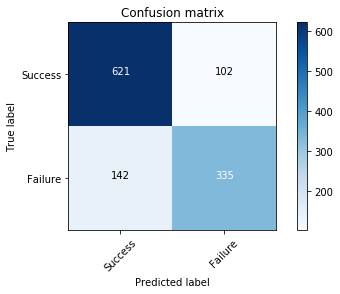

In [72]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5,6,7], 
              'p':[1,2],
              'weights':['uniform','distance']}
clf_knn = get_best_model(knn,parameters)
model_fit(model=clf_knn, feature_imp=False)

### Naive Bayes


--- Train Set -----------------------------
Accuracy: 0.71992 +/- 0.0130
AUC: 0.78444 +/- 0.0119

--- Validation Set -----------------------------
Accuracy: 0.70915 +/- 0.0139
AUC: 0.77267 +/- 0.0286
-----------------------------------------------


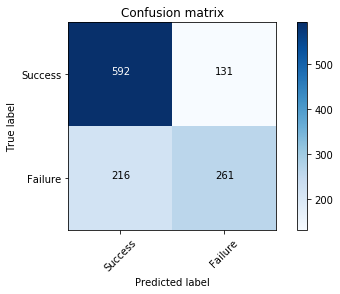

In [73]:
clf_nb = GaussianNB()
model_fit(model=clf_nb,feature_imp=False)

### Logistic Regression

C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to


--- Best Parameters -----------------------------
{'C': 0.9, 'penalty': 'l2'}

--- Best Model -----------------------------
LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=3, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

--- Train Set -----------------------------


C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

Accuracy: 0.81530 +/- 0.0114


C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

AUC: 0.89950 +/- 0.0121

--- Validation Set -----------------------------
Accuracy: 0.80662 +/- 0.0161


C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

AUC: 0.88679 +/- 0.0130
-----------------------------------------------


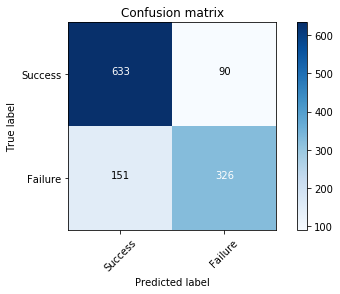

In [74]:
lg = LogisticRegression(random_state=3)
parameters = {'C':[0.8,0.9,1], 
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=False)

### Random Forest


--- Best Parameters -----------------------------
{'max_depth': 10, 'max_features': 14, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

--- Train Set -----------------------------
Accuracy: 0.85066 +/- 0.0063
AUC: 0.92409 +/- 0.0080

--- Validation Set -----------------------------
Accuracy: 0.82414 +/- 0.0168
AUC: 0.90579 +/- 0.0119
-----------------------------------------------


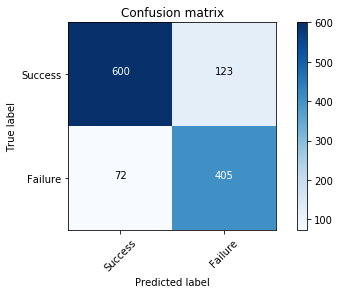

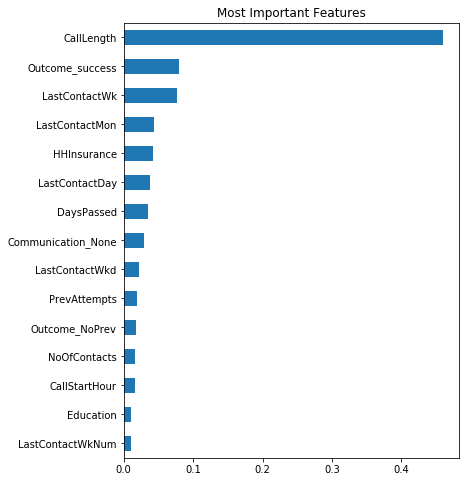

In [85]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
            'max_depth':[10],
            'max_features':[13,14],
            'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)
model_fit(model=clf_rf, feature_imp=True)

### SVM


--- Best Parameters -----------------------------
{'C': 1, 'gamma': 0.01}

--- Best Model -----------------------------
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=3, shrinking=True, tol=0.001,
  verbose=False)

--- Train Set -----------------------------
Accuracy: 0.83604 +/- 0.0214
AUC: 0.90466 +/- 0.0152

--- Validation Set -----------------------------
Accuracy: 0.77991 +/- 0.0260
AUC: 0.86015 +/- 0.0147
-----------------------------------------------


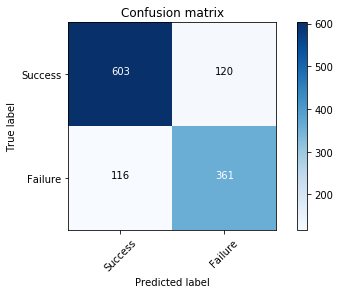

In [86]:
svc = svm.SVC(kernel='rbf', probability=True, random_state=3)
parameters = {'gamma': [0.005,0.01,0.02],
              'C': [0.5,1,5]}
clf_svc = get_best_model(svc, parameters)
model_fit(model=clf_svc,feature_imp=False)

### XGBOOST


--- Best Parameters -----------------------------
{'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.8}

--- Best Model -----------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=1000, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.8,
       tree_method='exact', validate_parameters=1, verbosity=None)

--- Train Set -----------------------------
Accuracy: 0.85495 +/- 0.0076
AUC: 0.93385 +/- 0.0072

--- Validation Set -----------------------------
Accuracy: 0.83495 +/- 0.0314
AUC: 0.91335 +/- 0.0147
-------

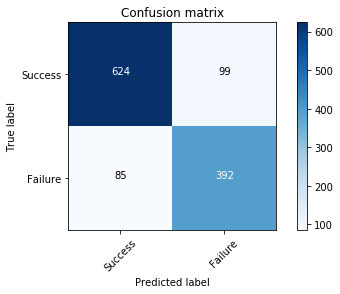

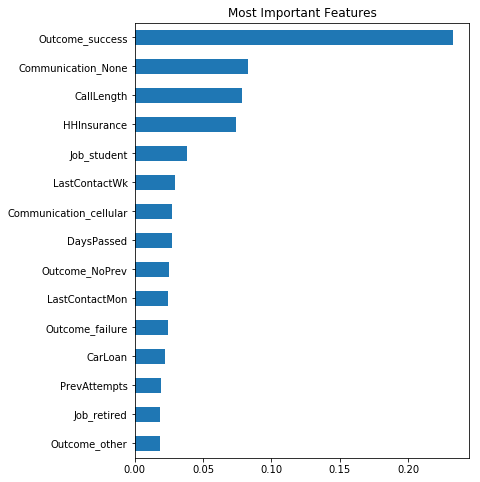

In [87]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
parameters={'n_estimators':[900,1000,1100],
            'learning_rate':[0.01],
            'max_depth':[8],
            'min_child_weight':[1],
            'subsample':[0.8],
            'colsample_bytree':[0.3,0.4,0.5]}
clf_xgb= get_best_model(xgb,parameters)
model_fit(model=clf_xgb, feature_imp=True)

### Model Evaluation

In [88]:
clfs= [clf_knn, clf_nb, clf_lg, clf_rf, clf_svc, clf_xgb]
index =['K-Nearest Neighbors','Naive Bayes','Logistic Regression','Random Forest','Support Vector Machines','XGBoost']
scores=[]
for clf in clfs:
    score = np.mean(cross_val_score(clf,x_test,y_test,cv=5,scoring = 'accuracy'))
    scores = np.append(scores,score)
models = pd.Series(scores,index=index)
models.sort_values(ascending=False)

C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

XGBoost                    0.834946
Random Forest              0.824136
Logistic Regression        0.807452
Support Vector Machines    0.779914
K-Nearest Neighbors        0.764073
Naive Bayes                0.709149
dtype: float64

### Ensemble Voting

In [89]:
clf_vc = VotingClassifier(estimators=[('xgb', clf_xgb),                                       
                                      ('rf', clf_rf),
                                      ('lg', clf_lg), 
                                      ('svc', clf_svc)], 
                          voting='hard',
                          weights=[4,4,1,1])
clf_vc = clf_vc.fit(x_train, y_train)

C:\Users\PRADYUM\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Final Result

In [90]:
print('Final Model Accuracy: %.5f'%(accuracy_score(y_test, clf_vc.predict(x_test))))

Final Model Accuracy: 0.83667
